# 📊 Análise de Crédito com Modelos Preditivos

## Contexto
Conceder crédito é sempre um equilíbrio delicado: de um lado, a instituição deseja ampliar o número de clientes aprovados; de outro, precisa minimizar o risco de inadimplência.  
O objetivo desta análise foi **identificar quais fatores influenciam mais a classificação de um cliente em "bom" ou "mau pagador"**, e avaliar diferentes modelos preditivos para apoiar a tomada de decisão.

In [1]:
!pip install mlflow

import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, roc_curve
)
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable


/home/wallingson12/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
credito = pd.read_csv(r'/home/wallingson12/Github/Data science and ML/Análise de crédito/credit.csv')

print(f"Colunas:{credito.columns}")

print(f"Número de linhas: {credito.shape[0]}")
print(f"Número de colunas: {credito.shape[1]}")

Colunas:Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')
Número de linhas: 1000
Número de colunas: 21


In [3]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


# Abordagem
Para responder a essas perguntas, seguimos três etapas principais:

1. **Preparação dos dados**  
   - Seleção de variáveis como status da conta, histórico de crédito, valor solicitado, tempo de residência, idade, emprego, entre outras. 
   - Transformação de variáveis categóricas em numéricas e normalização para equilibrar as escalas.  
   - Separação dos dados em treino (70%) e teste (30%).  

2. **Modelagem**  
   Foram testados diferentes algoritmos de classificação:  
   - **Regressão Logística**  
   - **Árvore de Decisão**  
   - **SVM (Support Vector Machine)**  
   - **Random Forest**  
   - **Rede Neural Artificial**  

3. **Avaliação e Interpretabilidade**  
   - Utilização de métricas de acurácia, precisão, recall e F1-Score.  
   - Uso do **SHAP** e dos **coeficientes dos modelos lineares** para entender a importância das variáveis.  


# Seleção de variáveis

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap

# # Selecionar variáveis preditoras específicas e alvo
variaveis = [
    'checking_status', 'duration', 'credit_history', 'purpose',
    'credit_amount', 'savings_status', 'employment',
    'installment_commitment', 'personal_status', 'other_parties',
    'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
    'housing', 'existing_credits', 'job', 'num_dependents',
    'own_telephone', 'foreign_worker'
]

X = credito[variaveis]
y = credito['class']

# Separação de tipos de variáveis

In [5]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

# Pré-processamento

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

#vPré-processamento

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# tuning

*Regressão Logística*

In [8]:
pipe_log = Pipeline([
    ('prep', preprocess_scaled),
    ('model', LogisticRegression(max_iter=1000))
])

param_log = [
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__solver': ['lbfgs'],
        'model__penalty': ['l2'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__solver': ['saga'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    }
]

grid_log = GridSearchCV(
    pipe_log,
    param_log,
    cv=5,
    scoring='f1_weighted'
)

grid_log.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=1000))])
,param_grid,"[{'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced'], 'model__penalty': ['l1', 'l2'], 'model__solver': ['liblinear']}, {'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced'], 'model__penalty': ['l2'], 'model__solver': ['lbfgs']}, ...]"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


*Árvore de Decisão*

In [9]:
pipe_tree = Pipeline([
    ('prep', preprocess_tree),
    ('model', DecisionTreeClassifier(random_state=42))
])

param_tree = {
    'model__max_depth': [None, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [None, 'balanced']
}

grid_tree = GridSearchCV(
    pipe_tree,
    param_tree,
    cv=5,
    scoring='f1_weighted'
)

grid_tree.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__class_weight': [None, 'balanced'], 'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 5, ...], 'model__max_features': [None, 'sqrt', ...], ...}"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


*SVM*

In [10]:
pipe_svm = Pipeline([
    ('prep', preprocess_scaled),
    ('model', SVC())
])

param_svm = [
    {
        'model__kernel': ['linear'],
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__kernel': ['rbf'],
        'model__C': [0.001, 0.01, 0.1, 1, 10],
        'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__kernel': ['poly'],
        'model__degree': [2, 3],
        'model__C': [0.1, 1],
        'model__gamma': ['scale', 'auto']
    }
]

grid_svm = GridSearchCV(
    pipe_svm,
    param_svm,
    cv=5,
    scoring='f1_weighted'
)

grid_svm.fit(X_train, y_train)

,estimator,"Pipeline(step...del', SVC())])"
,param_grid,"[{'model__C': [0.001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__kernel': ['linear']}, {'model__C': [0.001, 0.01, ...], 'model__class_weight': [None, 'balanced'], 'model__gamma': ['scale', 'auto', ...], 'model__kernel': ['rbf']}, ...]"
,scoring,'f1_weighted'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


*Random Forest*

In [11]:
pipe_rf = Pipeline([
    ('prep', preprocess_tree),
    ('model', RandomForestClassifier(random_state=42))
])

param_rf = [
    {
        'model__bootstrap': [True],
        'model__n_estimators': [200, 400],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2'],
        'model__max_samples': [None, 0.7, 0.9],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__bootstrap': [False],
        'model__n_estimators': [200, 400],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2'],
        'model__class_weight': [None, 'balanced']
    }
]

grid_rf = GridSearchCV(
    pipe_rf,
    param_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'model__bootstrap': [True], 'model__class_weight': [None, 'balanced'], 'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 'log2'], ...}, {'model__bootstrap': [False], 'model__class_weight': [None, 'balanced'], 'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 'log2'], ...}]"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


*Avaliação*

In [12]:
models = {
    'Logística': grid_log,
    'Árvore': grid_tree,
    'SVM': grid_svm,
    'Random Forest': grid_rf
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)

    results[name] = {
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    }

results_df = pd.DataFrame(results).T
print(results_df)

               Acurácia  Precisão    Recall  F1-score
Logística      0.740000  0.728749  0.740000  0.732088
Árvore         0.660000  0.649318  0.660000  0.653953
SVM            0.766667  0.756579  0.766667  0.758498
Random Forest  0.743333  0.731778  0.743333  0.734941


## Análise de Importância de Variáveis

Com o objetivo de compreender quais variáveis exercem maior influência nas predições dos modelos e fundamentar a redução do espaço de atributos, foi realizada uma análise de importância das variáveis utilizando abordagens específicas para cada algoritmo empregado.

Inicialmente, as variáveis foram avaliadas no nível de categorias (dummies), permitindo identificar padrões locais e globais de contribuição ao resultado do modelo.
    
Em seguida, essas contribuições foram interpretadas e agregadas ao nível das variáveis originais, de forma a preservar a interpretabilidade e reduzir a complexidade do modelo.

Para a Árvore de Decisão, foi utilizada a metodologia SHAP (SHapley Additive exPlanations), que permite quantificar a contribuição de cada variável para a predição de instâncias individuais, evidenciando tanto o impacto quanto a direção da influência de cada atributo.

No caso da Regressão Logística, a importância das variáveis foi avaliada por meio dos coeficientes estimados pelo modelo, considerando seu sinal e magnitude como indicadores da influência positiva ou negativa sobre a variável alvo.

Para o modelo SVM, adotou-se a versão com kernel linear, possibilitando a interpretação direta dos coeficientes do hiperplano separador, de forma análoga à regressão logística.

A partir dessas análises, foram selecionadas as variáveis originais que concentraram maior contribuição explicativa, justificando a exclusão de atributos redundantes ou de baixo impacto, resultando em modelos mais simples, interpretáveis e com menor risco de overfitting.

**ANÁLISE DE VARIÁVEIS COM SHAP - DECISION TREE**



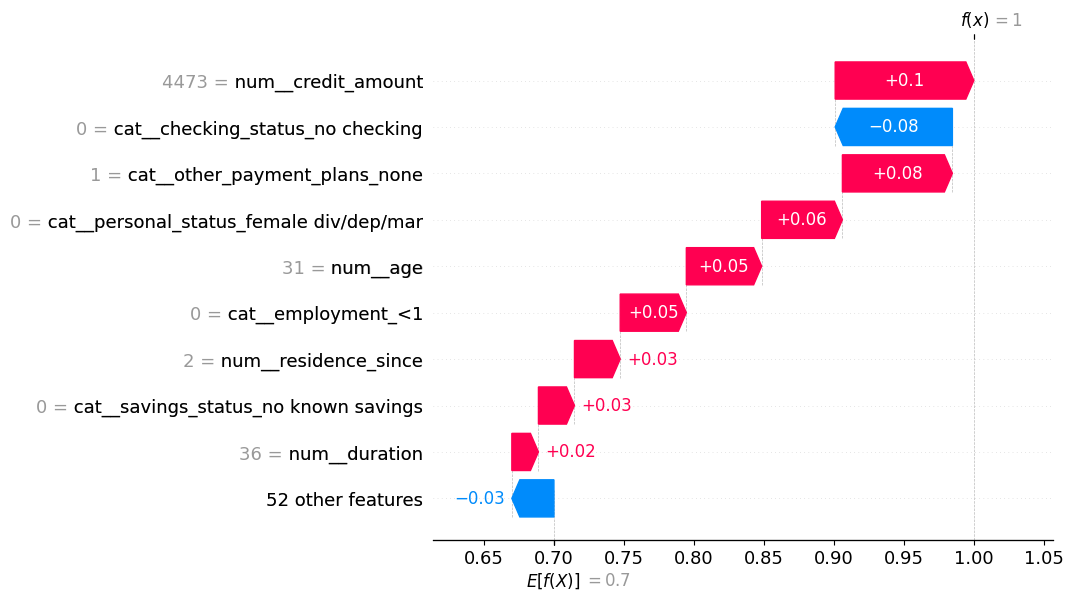

In [15]:
i = 0  # instância

single_explanation = shap.Explanation(
    values=shap_values.values[i, :, 1],      # classe positiva
    base_values=shap_values.base_values[i, 1],
    data=X_train_transformed[i],
    feature_names=feature_names
)

shap.plots.waterfall(single_explanation)

**ANÁLISE DE VARIÁVEIS COM SHAP - REGRESSION LOGISTIC**

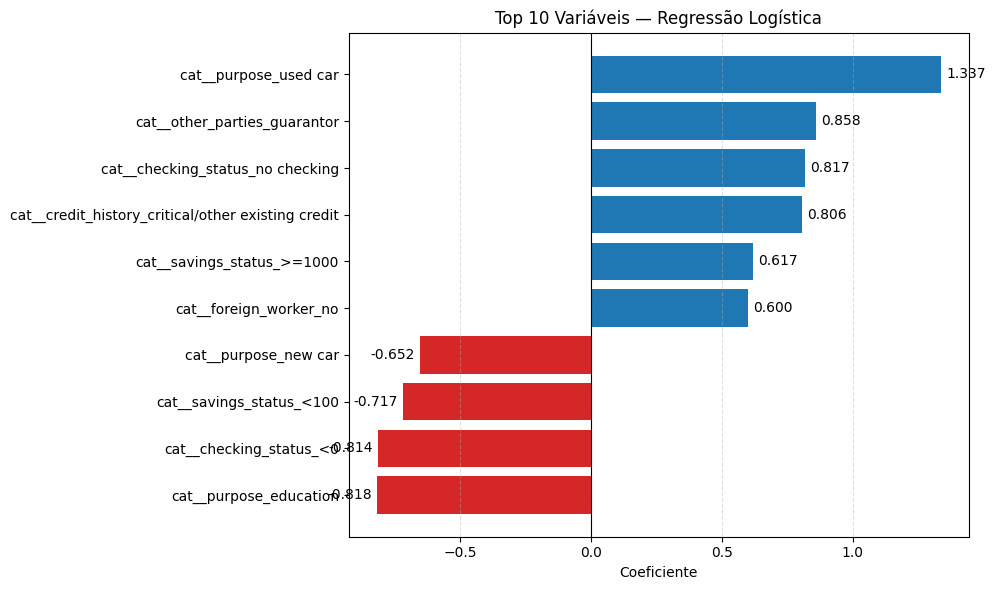


IMPORTÂNCIA DAS VARIÁVEIS (ORDENADO)

                                          Variável  Coeficiente  Importância (abs)
                             cat__purpose_used car      1.33663           1.336627
                      cat__other_parties_guarantor      0.85786           0.857862
                            cat__purpose_education     -0.81795           0.817946
                  cat__checking_status_no checking      0.81744           0.817436
                           cat__checking_status_<0     -0.81433           0.814333
cat__credit_history_critical/other existing credit      0.80638           0.806378
                          cat__savings_status_<100     -0.71722           0.717216
                              cat__purpose_new car     -0.65209           0.652087
                        cat__savings_status_>=1000      0.61747           0.617468
                            cat__foreign_worker_no      0.59987           0.599867
         cat__property_magnitude_no known proper

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# =====================
# 📌 MODELO CORRETO
# =====================
best_log = grid_log.best_estimator_
preprocess = best_log.named_steps['prep']
model = best_log.named_steps['model']

# Coeficientes e nomes reais das features
coef = model.coef_[0]
features = preprocess.get_feature_names_out()

# DataFrame completo
coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coef
})

# Importância absoluta
coef_df['Importância (abs)'] = coef_df['Coeficiente'].abs()

# =====================
# 📊 GRÁFICO — TOP 10
# =====================
top10 = (
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .head(10)
    .sort_values(by='Coeficiente')
)

colors = top10['Coeficiente'].apply(
    lambda x: '#1f77b4' if x > 0 else '#d62728'
)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    top10['Variável'],
    top10['Coeficiente'],
    color=colors
)

plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Coeficiente')
plt.title('Top 10 Variáveis — Regressão Logística')
plt.grid(axis='x', linestyle='--', alpha=0.4)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width + np.sign(width) * 0.02,
        bar.get_y() + bar.get_height() / 2,
        f'{width:.3f}',
        va='center',
        ha='left' if width > 0 else 'right'
    )

plt.tight_layout()
plt.show()

# =====================
# 📋 PRINT — TODAS
# =====================
print('\nIMPORTÂNCIA DAS VARIÁVEIS (ORDENADO)\n')
print(
    coef_df
    .sort_values(by='Importância (abs)', ascending=False)
    .assign(Coeficiente=lambda x: x['Coeficiente'].round(5))
    [['Variável', 'Coeficiente', 'Importância (abs)']]
    .to_string(index=False)
)

**ANÁLISE DE VARIÁVEIS COM SHAP - SVM**

⚠️ SVM NÃO LINEAR — usando SHAP (progress bar desativado)


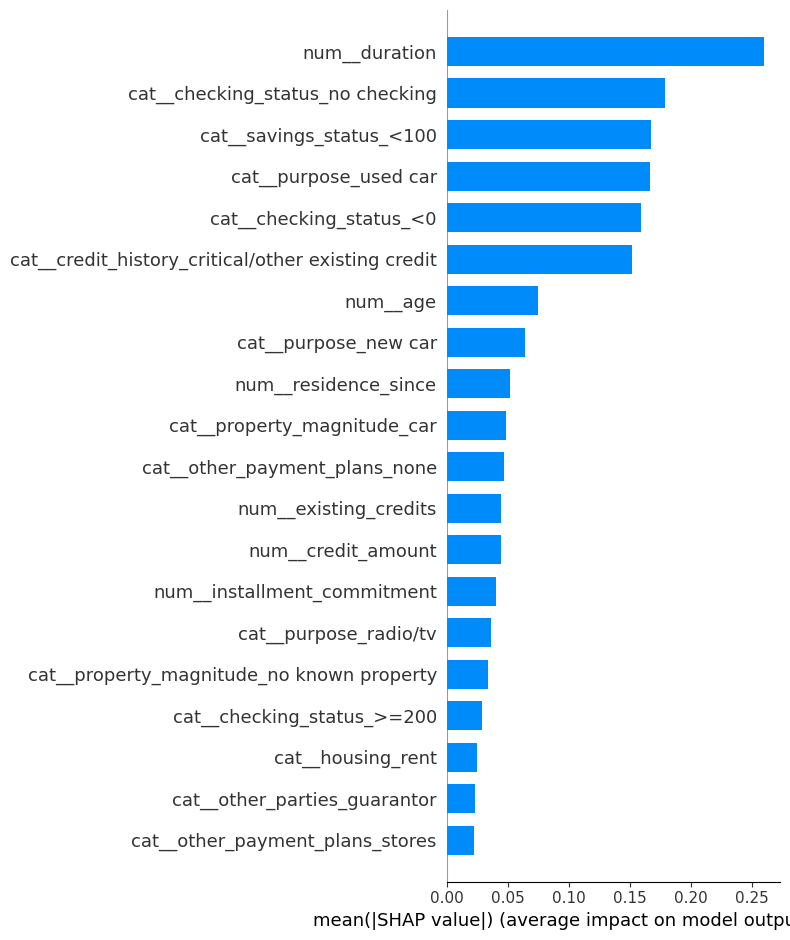

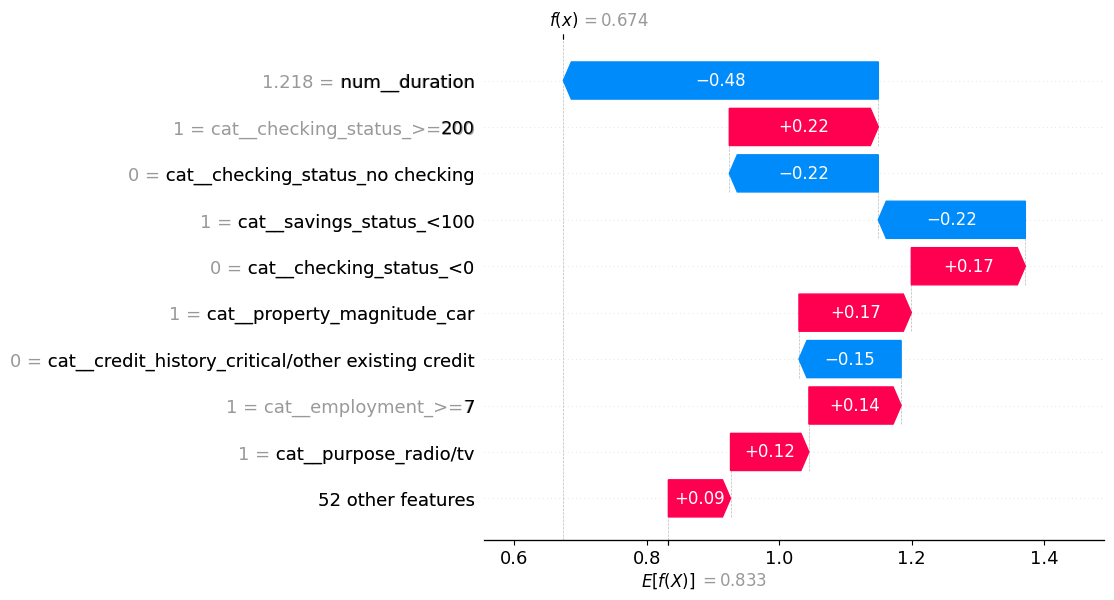

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

# =====================
# 📌 MODELO CORRETO
# =====================
best_svm = grid_svm.best_estimator_

preprocess = best_svm.named_steps['prep']
model = best_svm.named_steps['model']

# =====================
# 🔁 DADOS TRANSFORMADOS
# =====================
X_train_t = preprocess.transform(X_train)
if hasattr(X_train_t, "toarray"):
    X_train_t = X_train_t.toarray()

feature_names = preprocess.get_feature_names_out()

# =====================
# 🔎 INTERPRETAÇÃO
# =====================
if model.kernel == 'linear':

    coef = model.coef_[0]

    coef_df = pd.DataFrame({
        'Variável': feature_names,
        'Coeficiente': coef
    })

    coef_df['Importância (abs)'] = coef_df['Coeficiente'].abs()

    top10 = (
        coef_df
        .sort_values(by='Importância (abs)', ascending=False)
        .head(10)
        .sort_values(by='Coeficiente')
    )

    colors = top10['Coeficiente'].apply(
        lambda x: '#1f77b4' if x > 0 else '#d62728'
    )

    plt.figure(figsize=(10, 6))
    bars = plt.barh(top10['Variável'], top10['Coeficiente'], color=colors)

    plt.axvline(0, color='black', linewidth=0.8)
    plt.xlabel('Coeficiente')
    plt.title('Top 10 Variáveis — SVM Linear')
    plt.grid(axis='x', linestyle='--', alpha=0.4)

    for bar in bars:
        width = bar.get_width()
        plt.text(
            width + np.sign(width) * 0.02,
            bar.get_y() + bar.get_height() / 2,
            f'{width:.3f}',
            va='center',
            ha='left' if width > 0 else 'right'
        )

    plt.tight_layout()
    plt.show()

    print('\nIMPORTÂNCIA DAS VARIÁVEIS — SVM LINEAR\n')
    print(
        coef_df
        .sort_values(by='Importância (abs)', ascending=False)
        .assign(Coeficiente=lambda x: x['Coeficiente'].round(5))
        [['Variável', 'Coeficiente', 'Importância (abs)']]
        .to_string(index=False)
    )

else:
    print('⚠️ SVM NÃO LINEAR — usando SHAP (progress bar desativado)')

    def svm_decision(X):
        return model.decision_function(X)

    background = shap.sample(X_train_t, 50, random_state=42)

    explainer = shap.KernelExplainer(
        svm_decision,
        background
    )

    X_exp = X_train_t[:20]

    # 🔥 AQUI ESTÁ A CORREÇÃO
    shap_values = explainer.shap_values(
        X_exp,
        silent=True
    )

    shap.summary_plot(
        shap_values,
        X_exp,
        feature_names=feature_names,
        plot_type='bar'
    )

    i = 0
    exp = shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_exp[i],
        feature_names=feature_names
    )

    shap.plots.waterfall(exp)


# Testando a performqance do modelo apenas aplicando as colunas que parecem ter cse destacado

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =====================================================
# TARGET
# =====================================================
y = credito['class']

# Split ÚNICO para garantir comparação justa
X_dummy = pd.get_dummies(credito.drop(columns=['class']), drop_first=True)

X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_dummy, y, test_size=0.3, random_state=42, stratify=y
)

# =====================================================
# 1️⃣ REGRESSÃO LOGÍSTICA – VARIÁVEIS PURAS
# =====================================================
features_logistic = [
    'checking_status',
    'installment_commitment',
    'age',
    'credit_amount',
    'purpose',
    'duration',
    'credit_history'
]

cols_log = [c for c in X_train_full.columns if any(f in c for f in features_logistic)]

Xl_train = X_train_full[cols_log]
Xl_test = X_test_full[cols_log]

scaler_log = StandardScaler()
Xl_train = scaler_log.fit_transform(Xl_train)
Xl_test = scaler_log.transform(Xl_test)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(Xl_train, y_train)
y_pred_log = logistic_model.predict(Xl_test)

# =====================================================
# 2️⃣ SVM – VARIÁVEIS PURAS
# =====================================================
features_svm = [
    'checking_status',
    'credit_history',
    'installment_commitment',
    'purpose',
    'credit_amount',
    'age',
    'duration'
]

cols_svm = [c for c in X_train_full.columns if any(f in c for f in features_svm)]

Xs_train = X_train_full[cols_svm]
Xs_test = X_test_full[cols_svm]

scaler_svm = StandardScaler()
Xs_train = scaler_svm.fit_transform(Xs_train)
Xs_test = scaler_svm.transform(Xs_test)

svm_model = SVC(kernel='rbf')
svm_model.fit(Xs_train, y_train)
y_pred_svm = svm_model.predict(Xs_test)

# =====================================================
# 3️⃣ ÁRVORE DE DECISÃO – VARIÁVEIS PURAS
# =====================================================
features_tree = [
    'age',
    'credit_history',
    'purpose',
    'credit_amount',
    'duration'
]

cols_tree = [c for c in X_train_full.columns if any(f in c for f in features_tree)]

Xt_train = X_train_full[cols_tree]
Xt_test = X_test_full[cols_tree]

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(Xt_train, y_train)
y_pred_tree = tree_model.predict(Xt_test)

# =====================================================
# 4️⃣ AVALIAÇÃO FINAL
# =====================================================
results = {
    "Regressão Logística": {
        "Acurácia": accuracy_score(y_test, y_pred_log),
        "Precisão": precision_score(y_test, y_pred_log, average='weighted'),
        "Recall": recall_score(y_test, y_pred_log, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_log, average='weighted')
    },
    "SVM": {
        "Acurácia": accuracy_score(y_test, y_pred_svm),
        "Precisão": precision_score(y_test, y_pred_svm, average='weighted'),
        "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_svm, average='weighted')
    },
    "Árvore de Decisão": {
        "Acurácia": accuracy_score(y_test, y_pred_tree),
        "Precisão": precision_score(y_test, y_pred_tree, average='weighted'),
        "Recall": recall_score(y_test, y_pred_tree, average='weighted'),
        "F1-score": f1_score(y_test, y_pred_tree, average='weighted')
    }
}

results_df = pd.DataFrame(results).T
print(results_df)

                     Acurácia  Precisão    Recall  F1-score
Regressão Logística  0.750000  0.734584  0.750000  0.734067
SVM                  0.750000  0.735294  0.750000  0.720430
Árvore de Decisão    0.616667  0.629957  0.616667  0.622550


## Conclusões
- A análise confirma que **não é apenas o valor do crédito solicitado que importa**, mas principalmente o histórico financeiro do cliente e a estabilidade de sua situação (emprego, residência).  
- Modelos explicáveis, como Regressão Logística e Árvores de Decisão, são particularmente úteis em contextos regulatórios e de auditoria, onde é preciso justificar a decisão de crédito.  
- Para aplicações práticas, recomenda-se **combinar acurácia e interpretabilidade**, adotando modelos como Regressão Logística ou Random Forest com análise SHAP para transparência.  

## Impacto para o Negócio
Com esse tipo de abordagem:  
- A instituição pode **reduzir perdas financeiras**, minimizando a concessão para perfis de alto risco.  
- É possível **criar políticas de crédito mais justas e transparentes**, reforçando a confiança dos clientes.  
- Os times de risco podem se apoiar em evidências quantitativas e visuais para comunicar suas decisões à diretoria.  